In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score
from pandas.tools.plotting import autocorrelation_plot
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tools.eval_measures import aicc
import itertools

plt.style.use('fivethirtyeight')

In [2]:
data=pd.read_csv("C:/Users/sujan/Downloads/eG_Ontap/cpu_util_nlensndm_SQL.csv")

### Data Pre-processing stage :

In [3]:
data.iloc[3]

Unnamed: 0                    Measurement Time
Unnamed: 1                                Data
Comparison Reports - Tests                 NaN
Name: 3, dtype: object

In [4]:
data.columns=data.iloc[3]

In [5]:
data.drop(columns=data.columns[2],axis=1)

3,Measurement Time,Data
0,",","Start Date : Feb 25, 2019 07:40 Hrs"
1,NLENSMSDB10:1433:Microsoft SQL Memory Usage/Me...,NaN
2,NaN,NaN
3,Measurement Time,Data
4,"Feb 25, 2019 07:41",95.9685
5,"Feb 25, 2019 07:46",95.9624
6,"Feb 25, 2019 07:51",96.4049
7,"Feb 25, 2019 07:56",96.469
8,"Feb 25, 2019 08:01",96.4782
9,"Feb 25, 2019 08:06",96.8139


In [6]:
data.columns

Index(['Measurement Time', 'Data', nan], dtype='object', name=3)

In [7]:
data.drop([0,1,2,3],axis=0,inplace=True)

In [8]:
data.drop(columns=data.columns[2],inplace=True)

In [9]:
data['Measurement Time']=pd.to_datetime(data['Measurement Time'])

In [10]:
data.set_index('Measurement Time',inplace=True)

In [14]:
data['Data']=data['Data'].astype(float)

# Ploting data 

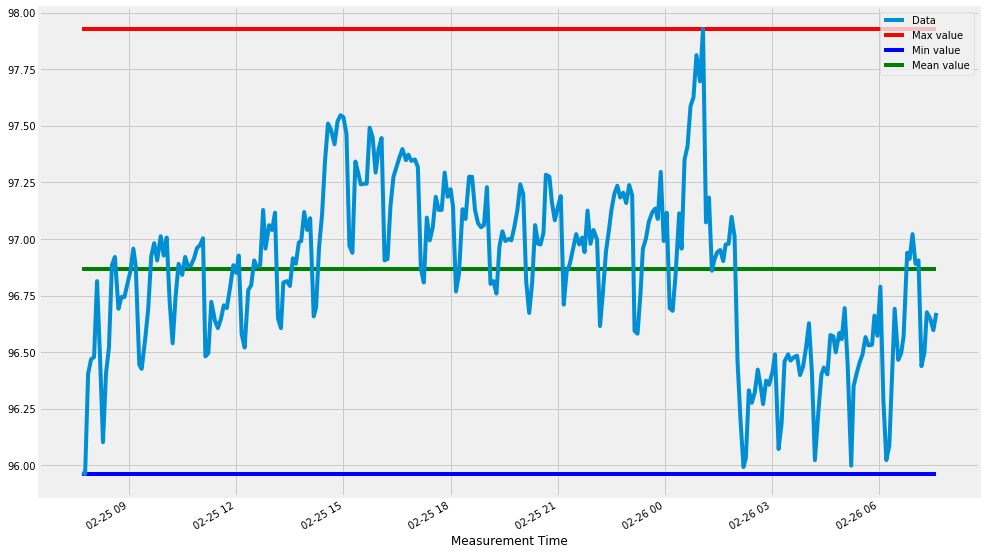

In [15]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10
#plt.figure(figsize=(12,15))
data.plot()
plt.hlines(y=data.max(),xmin=data.index.min(),xmax=data.index.max(),colors='r',label='Max value')
plt.hlines(y=data.min(),xmin=data.index.min(),xmax=data.index.max(),colors='b',label="Min value")
plt.hlines(y=data.mean(),xmin=data.index.min(),xmax=data.index.max(),colors='g',label="Mean value")
plt.legend()
plt.show()

#### P  is the auto-regressive part of the model. It allows us to incorporate the effect of past values into our model. Intuitively, this would be similar to stating that it is likely to be warm tomorrow if it has been warm the past 3 days.

#### d is the integrated part of the model. This includes terms in the model that incorporate the amount of differencing (i.e. the number of past time points to subtract from the current value) to apply to the time series. Intuitively, this would be similar to stating that it is likely to be same temperature tomorrow if the difference in temperature in the last three days has been very small.

#### q is the moving average part of the model. This allows us to set the error of our model as a linear combination of the error values observed at previous time points in the past.

#### When dealing with seasonal effects, we make use of the seasonal ARIMA, which is denoted as ARIMA(p,d,q)(P,D,Q)s.
####  The term s is the periodicity of the time series (4 for quarterly periods, 12 for yearly periods, etc.).


In [16]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))


Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


### Automating the optimal values for pqd and PQD- Seasonal components 

We can now use the triplets of parameters defined above to automate the process of training and evaluating ARIMA models on different combinations. In Statistics and Machine Learning, this process is known as grid search (or hyperparameter optimization) for model selection.

In [17]:
import warnings
warnings.filterwarnings("ignore")

aic=[]
seasonal=[]
parameters=[]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        #seasonal_param.append(param_seasonal)
        
        print('Parameters:{} Seasonal_Parameters : {}'.format(param,param_seasonal))
        
        model = SARIMAX(data,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
        results=model.fit()
        
        
        print('Param :{} Seasonal order: {} AIC:{}'.format(param,param_seasonal,results.aic))
        aic.append(results.aic)
        parameters.append(param)
        seasonal.append(param_seasonal)
        
        continue
        #print('Seasonal_parameters: {}'.format(param_seasonal))
        #model = SARIMAX(data,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
        #results = mod.fit()
        #aic.append(results.aic)
        #seasonal_param.append(param_seasonal)
        #params.append(param)
        #print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        #continue
        
       

Parameters:(0, 0, 0) Seasonal_Parameters : (0, 0, 0, 12)
Param :(0, 0, 0) Seasonal order: (0, 0, 0, 12) AIC:3441.578882566262
Parameters:(0, 0, 0) Seasonal_Parameters : (0, 0, 1, 12)
Param :(0, 0, 0) Seasonal order: (0, 0, 1, 12) AIC:3302.1918773274274
Parameters:(0, 0, 0) Seasonal_Parameters : (0, 1, 0, 12)
Param :(0, 0, 0) Seasonal order: (0, 1, 0, 12) AIC:99.43499627390061
Parameters:(0, 0, 0) Seasonal_Parameters : (0, 1, 1, 12)
Param :(0, 0, 0) Seasonal order: (0, 1, 1, 12) AIC:76.10461450423624
Parameters:(0, 0, 0) Seasonal_Parameters : (1, 0, 0, 12)
Param :(0, 0, 0) Seasonal order: (1, 0, 0, 12) AIC:106.56563093975554
Parameters:(0, 0, 0) Seasonal_Parameters : (1, 0, 1, 12)
Param :(0, 0, 0) Seasonal order: (1, 0, 1, 12) AIC:87.07838284951005
Parameters:(0, 0, 0) Seasonal_Parameters : (1, 1, 0, 12)
Param :(0, 0, 0) Seasonal order: (1, 1, 0, 12) AIC:80.40901678375735
Parameters:(0, 0, 0) Seasonal_Parameters : (1, 1, 1, 12)
Param :(0, 0, 0) Seasonal order: (1, 1, 1, 12) AIC:69.72282

In [18]:
Grid_search=pd.DataFrame()

In [19]:
Grid_search['Parameters']=parameters

In [20]:
Grid_search['Seasonal']=seasonal
Grid_search['AIC']=aic

## Grid Search Table 
##### The table below shows an enumeration on possible values of AIC 

In [21]:
Grid_search

,Parameters,Seasonal,AIC
0,"(0, 0, 0)","(0, 0, 0, 12)",3441.578883
1,"(0, 0, 0)","(0, 0, 1, 12)",3302.191877
2,"(0, 0, 0)","(0, 1, 0, 12)",99.434996
3,"(0, 0, 0)","(0, 1, 1, 12)",76.104615
4,"(0, 0, 0)","(1, 0, 0, 12)",106.565631
5,"(0, 0, 0)","(1, 0, 1, 12)",87.078383
6,"(0, 0, 0)","(1, 1, 0, 12)",80.409017
7,"(0, 0, 0)","(1, 1, 1, 12)",69.722829
8,"(0, 0, 1)","(0, 0, 0, 12)",3041.892564
9,"(0, 0, 1)","(0, 0, 1, 12)",2585.264182


The optimal parameters used for predicting SARIMA is as follows:

In [22]:
Grid_search.loc[Grid_search['AIC']==np.min(Grid_search['AIC'])]

,Parameters,Seasonal,AIC
47,"(1, 0, 1)","(1, 1, 1, 12)",-271.016403


#### Conclusion

The parameters with (1,0,1) and (0,1,1,12) has the least AIC score of 240.978. Hence this value can be used for input for parameters choosen for SARIMA.